# L12_transient_Universe_nested

remember to normalize the likelihood if you want the evidence.. here we just want the ratio so who care

Let's go back to our previous example on the astrophysical transient.


8) Fit the same model from before with the same priors,  but this time use nested sampling.

$y = b$, for $t<t_0$

$y = b + A\exp[-\alpha(t-t_0)]$, for $t\geq t_0$

Be careful with how you transform your parameter space into a unit hypercube for the nested sampling priors (I used `ppf` from `scipy.stats.uniform`, but there are other ways to do it)

An appropriate check on whether you have done things correctly is that the posterior samples you get from the burst analysis here should give an equivalent corner plot to the MCMC you did earlier.

7) Another possible model that may explain the data is a Gaussian profile described by:

$y = b + A\exp[-(t-t_0)^2 / 2\sigma_W^2]$

Fit this model usign nested sampling and reasonable priors (this time is up to you to decide...)

9) Unlike MCMCs, nested sampling provides the Bayesian evidence. Compute the Bayesian evidence for this Gaussian model, and for the original burst model. Which model is the favored description of the data?

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import corner
import warnings; warnings.simplefilter('ignore')
import dynesty

C:\Users\carlo\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
data_file = '/Users/carlo/Desktop/Astrofisica/astrostatistics/astrostatistics_bicocca_2022/solutions/transient.npy'
data = np.load(data_file)

t        = data[:,0]  #first column: time
flux     = data[:,1]  #second column: flux
err_flux = data[:,2]  #third column: flux uncertainty

In [3]:
def burst_back(t, A, b, t_0, alpha):
    y = np.zeros(len(t))
    for i in range(len(t)):
        if t[i] < t_0:
            y[i] = b
        else:
            y[i] = b + A*np.exp(-alpha*(t[i]-t_0))
    return y

The priors on the parameters are defined in the following way:

- $p(A)$ is uniform in the interval (0, 50);
- $p(b)$ is uniform in the interval (0, 50);
- $p(t_0)$ is uniform in the interval (0,100);
- $p(\log \alpha)$ is uniform in the interval (-5, 5), which makes $p(\alpha)$ a logunifom distribution between (e$^{-5}$, e$^{5}$).

But in dynesty priors should be defined starting from a unit cube ($u$). For this reason the prior on $\alpha$ is here defined using the inverse transform sampling, because in this way we are starting from a number between 0 and 1 (our unit cube) to get the correspondent value of the quantile function. This is not the only way, for example we could exponentiate the unit cube such that from a uniform distribution we can get to a loguniform one, with the appropriate limits.

$$u' = e^{10 
u}/e^5$$

In the cell below I show that these two processes are equivalent.

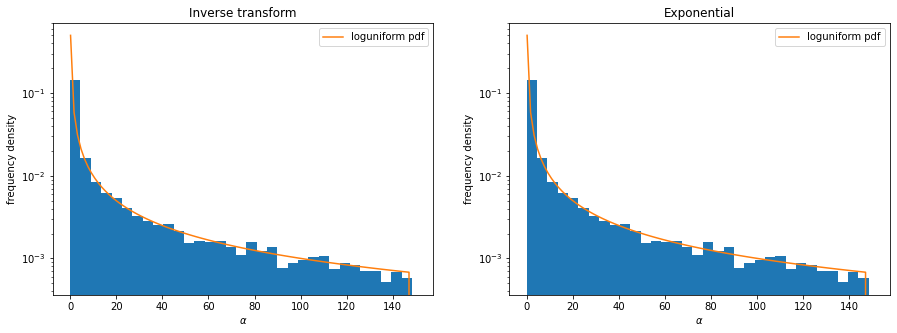

In [4]:
fig, ax = plt.subplots(1,2, figsize=(15, 5))

u = stats.uniform.rvs(size=10000)

ppf = stats.loguniform.ppf(u, np.exp(-5), np.exp(5))  #inverse sampling

new_u = np.exp(u*10)/np.exp(5) #exponential

ax[0].hist(ppf, bins=33, density=True)
ax[1].hist(new_u, bins=33, density=True)

titles = ['Inverse transform', 'Exponential']

for i in range(2):
    ax[i].plot(np.linspace(0.2,150, 100), stats.loguniform.pdf(np.linspace(0.2,150, 100), np.exp(-5), np.exp(5)), label='loguniform pdf')
    ax[i].set_yscale('log')
    ax[i].set_xlabel(r'$\alpha$')
    ax[i].set_ylabel('frequency density')
    ax[i].legend()
    ax[i].set_title(titles[i])

In [5]:
#defining the log(likelihood) and the prior on the parameters
ndim = 4 #number of dimensions (parameters to optimize)

def loglike(x):
    log_L = -0.5*np.sum((burst_back(t, x[0], x[1], x[2], x[3]) - flux)**2/err_flux**2)
    return log_L

def ptform(u):
    x = np.array(u)
    x[0] = u[0]*50   #A prior  
    x[1] = u[1]*50   #b prior
    x[2] = u[2]*100  #t_0 prior
    x[3] = stats.loguniform.ppf(u[3], np.exp(-5), np.exp(5))  #alpha prior
    #x[3] = np.exp(u[3]*10)/np.exp(5)
    return x


In [6]:
#running dynesty
sampler = dynesty.NestedSampler(loglike, ptform, ndim, nlive=500 )
sampler.run_nested()
sresults = sampler.results
sresults.summary()

7584it [00:37, 201.07it/s, +500 | bound: 31 | nc: 1 | ncall: 40472 | eff(%): 19.974 | loglstar:   -inf < -48.757 <    inf | logz: -63.137 +/-  0.236 | dlogz:  0.001 >  0.509]

Summary
nlive: 500
niter: 7584
ncall: 40472
eff(%): 19.974
logz: -63.137 +/-  0.236


In the next cell we can see some summary plots of the run. Nested sampling proceeds in a way such that we begin with a given number of extracted point, for each of these the Likelihood is evaluated and the point with the minimum Likelihood is attached to the chain and the associated evidence is evaluated, while a new point such that the Likelihood in the new point is bigger than the threshold is extracted. The threshold value is the minimum value found for the Likelihood, so it increases at each iteration while the prior volume decreases, as we can see in the second plot. Once the increasing in evidence is small and the stopping criterion is reached no more points are extracted, this could be seen in the first plot.

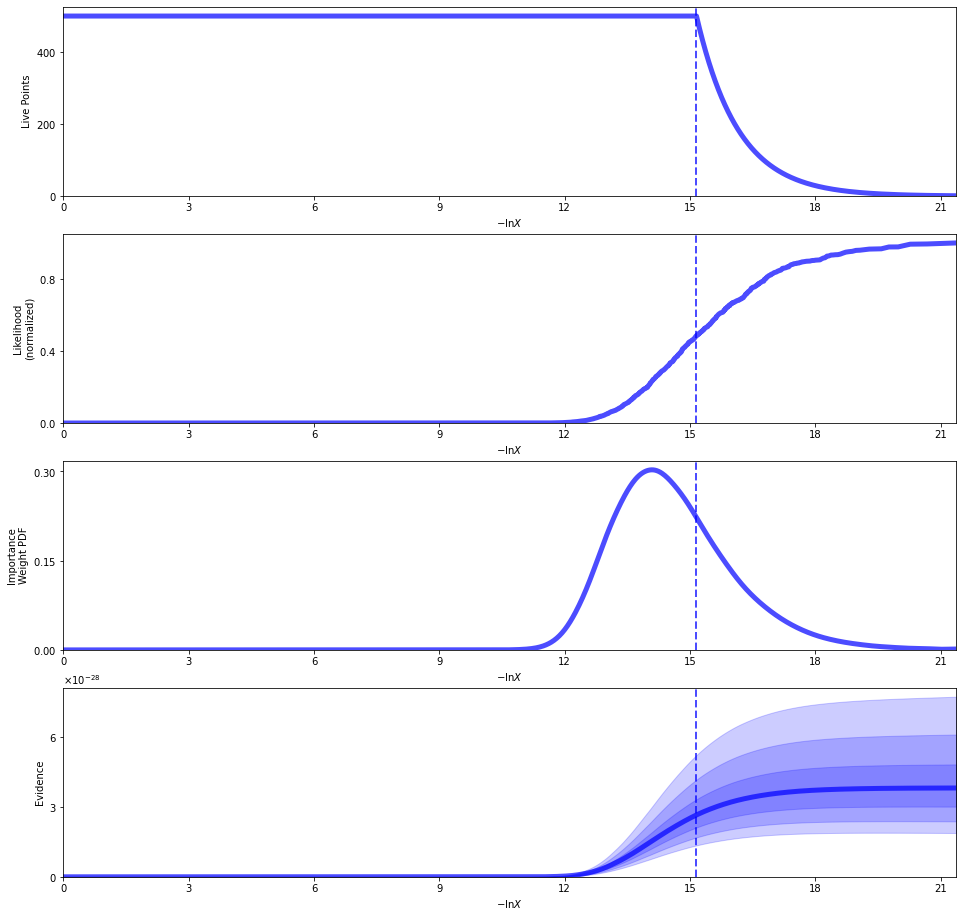

In [7]:
from dynesty import plotting as dyplot

# Plot a summary of the run.
rfig, raxes = dyplot.runplot(sresults)

Here I show the posterior of every parameter highlighting the extracted points from dynesty.

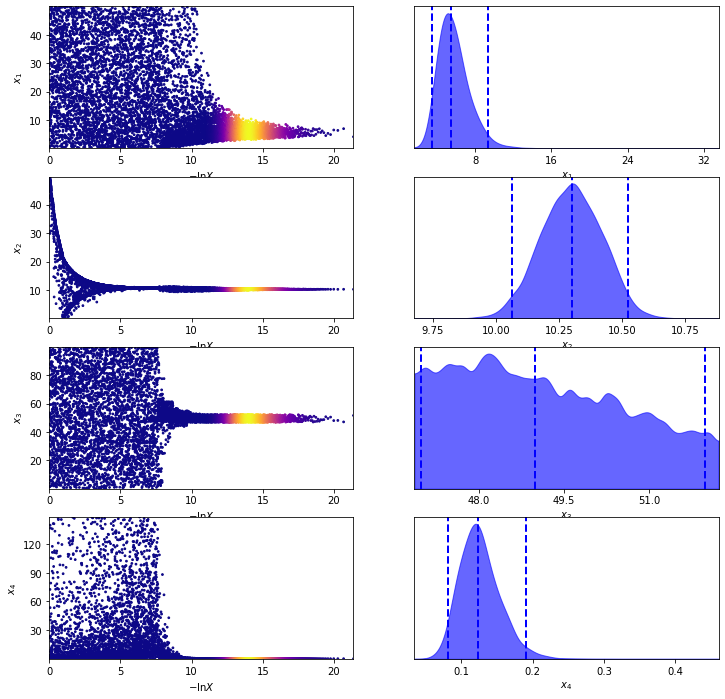

In [8]:
tfig, taxes = dyplot.traceplot(sresults)

In [9]:
from dynesty import utils as dyfunc

#Samples extracted
samples = sresults.samples 

#Normalized Weights = dZ/Ztot 
weights = np.exp(sresults.logwt - sresults.logz[-1])  # normalized weights

# Compute median and 1sigma intervals.
quantiles = [dyfunc.quantile(samps, [0.16, 0.50, 0.84], weights=weights)
             for samps in samples.T]
print('16-50-84 percentiles are: \nA : ', str(quantiles[0]), '\nb : ', str(quantiles[1]), '\nt0 : ', str(quantiles[2]), '\nalpha : ', str(quantiles[3]))

# Compute weighted mean and covariance.
mean, cov = dyfunc.mean_and_cov(samples, weights)
print('\nMean and covariance of parameters are: ' + str(mean) + '\n' + str(cov))

# Resample weighted samples.
samples_equal = dyfunc.resample_equal(samples, weights)

# Generate a new set of results with statistical+sampling uncertainties.
results_sim = dyfunc.simulate_run(sresults)

16-50-84 percentiles are: 
A :  [4.297060131906611, 5.487018987884435, 7.194732611078147] 
b :  [10.176464157636245, 10.301094896084336, 10.422876975246119] 
t0 :  [47.53945733697334, 48.9905836421541, 50.87217436873046] 
alpha :  [0.09892717338186882, 0.12311917708932149, 0.1530485781826649]

Mean and covariance of parameters are: [ 5.72935335 10.29842654 49.1570141   0.12594334]
[[ 2.46137040e+00  8.41913615e-03 -1.49916887e+00  2.44784531e-02]
 [ 8.41913615e-03  1.43848325e-02  4.39609384e-04  1.34445765e-03]
 [-1.49916887e+00  4.39609384e-04  2.12813359e+00 -3.99494247e-04]
 [ 2.44784531e-02  1.34445765e-03 -3.99494247e-04  7.78178864e-04]]


In [10]:
'''cfig, caxes = dyplot.cornerplot(sresults, color='blue', show_titles=True)''' #you could have a corner plot with dynesty

"cfig, caxes = dyplot.cornerplot(sresults, color='blue', show_titles=True)"

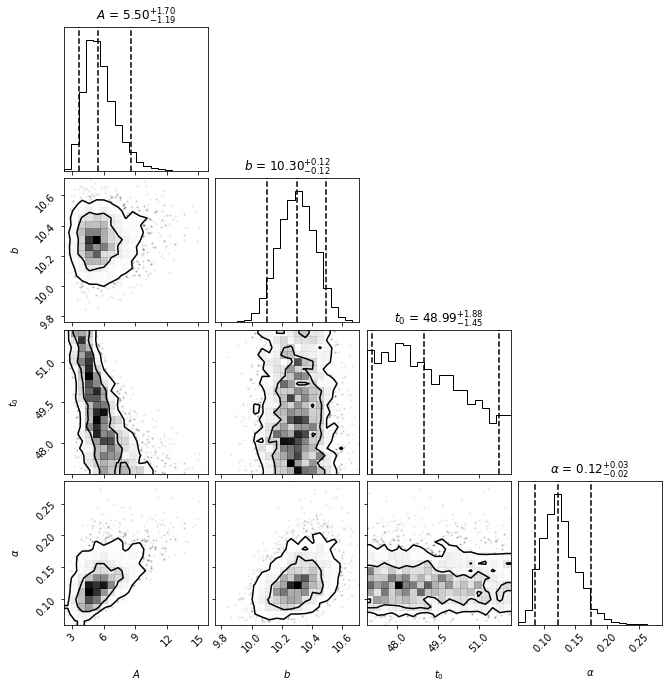

In [11]:
import corner
fig = corner.corner(samples_equal, levels=(0.68, 0.95), quantiles=(0.05, 0.5, 0.95), labels=[r'$A$', r'$b$', r'$t_{0}$', r'$\alpha$'],
                    title_quantiles = (0.05, 0.5, 0.95), show_titles=True)

Text(0.5, 1.0, '100 random results from the burst-back model')

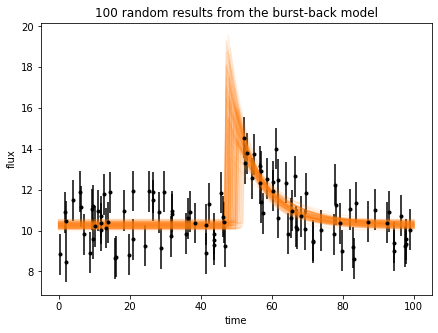

In [12]:
fig, ax = plt.subplots(1,1, figsize=(7,5))

ax.errorbar(t, flux, err_flux, fmt='.k')
t_sample = np.linspace(0,100,200)

random_ind = np.random.randint(low=0, high=len(samples_equal), size=100, dtype=int)
random_samples = samples_equal[random_ind]

for i in range(len(random_samples)):
    ax.plot(t_sample, burst_back(t_sample, random_samples[i,0], random_samples[i,1], random_samples[i,2], random_samples[i,3]),
           alpha = 0.1, c='tab:orange')
ax.set_xlabel('time')
ax.set_ylabel('flux')
ax.set_title('100 random results from the burst-back model')

Results seem alligned with the ones found with emcee!

### Gaussian model

Let's try to fit the same data with a Gaussian model to understand which model is more suitable.

In [13]:
#Gaussian function
def gaussian_model(t, A, b, t_0, sigma):
    return b + A*np.exp(-(t-t_0)**2/(2*sigma**2))  

In [14]:
#priors on parameters
def ptform_g(u):
    x = np.array(u)
    x[0] = stats.uniform(0, 50).ppf(u[0]) #A prior 
    x[1] = u[1]*50  #b prior
    x[2] = u[2]*100 #t_0 prior
    x[3] = stats.uniform.ppf(u[3], 0, 30) #sigma prior
    return x

#likelihood
def loglike_g(x):
    log_L = -0.5*np.sum((gaussian_model(t, x[0], x[1], x[2], x[3]) - flux)**2/err_flux**2)
    return log_L

In [15]:
sampler_g = dynesty.NestedSampler(loglike_g, ptform_g, ndim, nlive = 500)
sampler_g.run_nested()
sresults_g = sampler_g.results

8135it [01:18, 104.05it/s, +500 | bound: 31 | nc: 1 | ncall: 41510 | eff(%): 20.802 | loglstar:   -inf < -52.407 <    inf | logz: -67.952 +/-  0.248 | dlogz:  0.001 >  0.509]


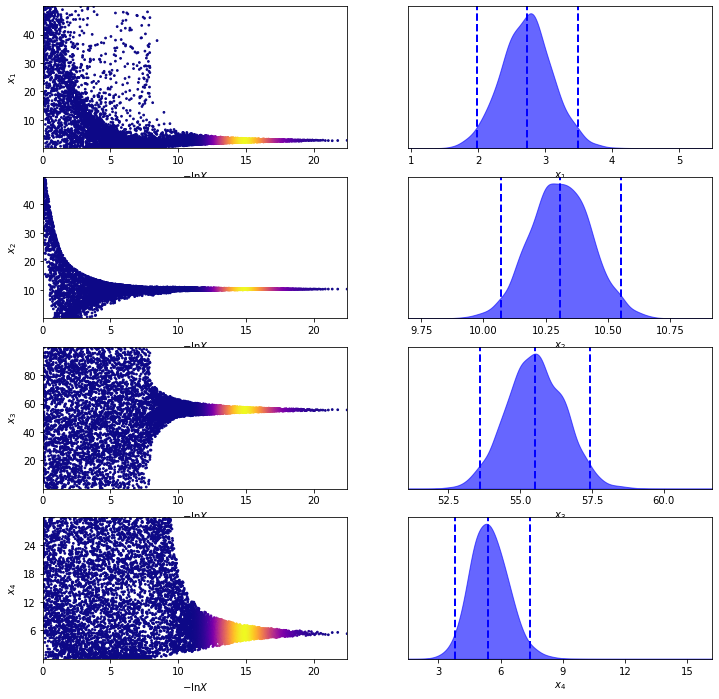

In [16]:
tfig, taxes = dyplot.traceplot(sresults_g)

In [17]:
#Samples extracted
samples_g = sresults_g.samples 

#Normalized Weights = dZ/Ztot 
weights_g = np.exp(sresults_g.logwt - sresults_g.logz[-1])  # normalized weights

# Compute median and 1sigma intervals.
quantiles_g = [dyfunc.quantile(samps, [0.16, 0.50, 0.84], weights=weights_g)
             for samps in samples_g.T]
print('16-50-84 percentiles are: \nA : ', str(quantiles_g[0]), '\nb : ', str(quantiles_g[1]), '\nt0 : ', str(quantiles_g[2]), '\nalpha : ', str(quantiles_g[3]))

# Compute weighted mean and covariance.
mean_g, cov_g = dyfunc.mean_and_cov(samples_g, weights_g)
print('\nMean and covariance of parameters are: ' + str(mean_g) + '\n' + str(cov_g))

# Resample weighted samples.
samples_equal_g = dyfunc.resample_equal(samples_g, weights_g)


16-50-84 percentiles are: 
A :  [2.3615158304929476, 2.733339520874333, 3.09453167571983] 
b :  [10.185029417287057, 10.308573522333257, 10.428700337518512] 
t0 :  [54.53073235851536, 55.504123098380646, 56.53778240567333] 
alpha :  [4.586331584233505, 5.387664022695835, 6.343625256837764]

Mean and covariance of parameters are: [ 2.72718481 10.3087704  55.52238238  5.4512911 ]
[[ 0.14556687 -0.0104843  -0.12124101 -0.14164336]
 [-0.0104843   0.01501751 -0.01830961 -0.04182951]
 [-0.12124101 -0.01830961  1.00122742  0.28811684]
 [-0.14164336 -0.04182951  0.28811684  0.82873854]]


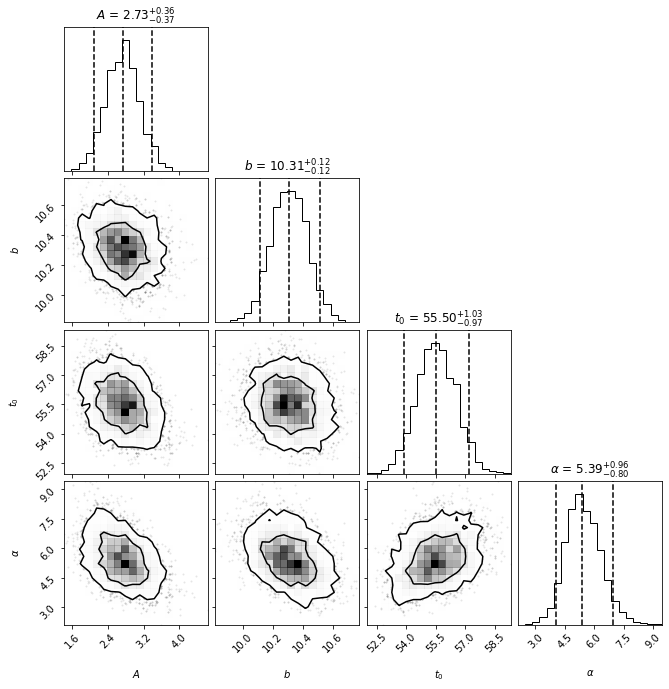

In [18]:
fig = corner.corner(samples_equal_g, levels=(0.68, 0.95), quantiles=(0.05, 0.5, 0.95), labels=[r'$A$', r'$b$', r'$t_{0}$', r'$\alpha$'],
                    title_quantiles = (0.05, 0.5, 0.95), show_titles=True)

Text(0.5, 1.0, '100 random results from the Gaussian model')

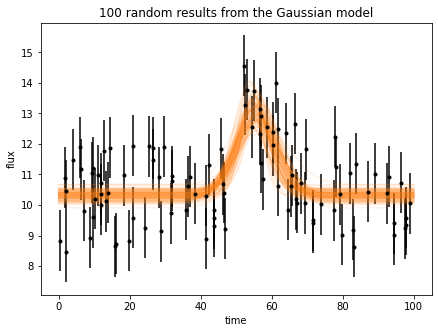

In [19]:
fig, ax = plt.subplots(1,1, figsize=(7,5))

ax.errorbar(t, flux, err_flux, fmt='.k')
t_sample = np.linspace(0,100,200)

random_ind = np.random.randint(low=0, high=len(samples_equal_g), size=100, dtype=int)
random_samples = samples_equal_g[random_ind]
for i in range(len(random_samples)):
    ax.plot(t_sample, gaussian_model(t_sample, random_samples[i,0], random_samples[i,1], random_samples[i,2], random_samples[i,3]),
           alpha = 0.1, c='tab:orange')
ax.set_xlabel('time')
ax.set_ylabel('flux')
ax.set_title('100 random results from the Gaussian model')

## Bayes factor

To understand which model is better at describing our data we can take the ratio of the evidences.

In [20]:
evid   = np.exp(sresults.logz[-1])
evid_g = np.exp(sresults_g.logz[-1])
print('The Bayes factor B_21 between M2 = burst-back and M1 = gaussian is: ', evid/evid_g)

The Bayes factor B_21 between M2 = burst-back and M1 = gaussian is:  123.35836138068149


Since in general the odds ratio is defined as:

$$O_{21} = \frac{p(M_2|D, I)}{p(M_1|D, I)} = B_{21}\frac{p(M_2|I)}{p(M_1|I)}$$

Assuming equal priors on the models the Bayes factor that we found is the same as the odds ratio. The value that we obtained is clearly stating (decisive evidence following Jeffreys' tables) that the burst-back model better represents our data.